In [1]:
%cd ..

/home/dawood/Workspace/compoundGAN


In [2]:
import torch
from torch.utils.data import DataLoader

from data.zinc import ZINC250K, ZINC_collate, Library
from models.gcn import GCN

from tqdm import tqdm
import networkx as nx

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
atom_list = [i for i in Library.atom_list]
atom_list.append('END')

In [4]:
model = GCN(58, 11, 256, [64, 128, 128])

In [5]:
dataset = ZINC250K('~/Datasets/ZINC250K/data.csv')
#dataset.seq_length = 4

In [6]:
dataset[0]

(DGLGraph(num_nodes=20, num_edges=62,
          ndata_schemes={'feats': Scheme(shape=(56,), dtype=torch.float32)}
          edata_schemes={'feats': Scheme(shape=(11,), dtype=torch.float32)}),
 tensor([[ 0],
         [ 1],
         [ 2],
         [ 3],
         [ 4],
         [ 5],
         [ 6],
         [ 7],
         [ 8],
         [ 9],
         [10],
         [11],
         [12],
         [13],
         [14],
         [15],
         [16],
         [17],
         [18],
         [19],
         [20]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 0., 0., 1.],
         ...,
         [0., 0., 1.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.]]),
 tensor([[ 2,  3,  0,  2],
         [ 0,  3,  0,  2],
         [ 2,  2,  0,  2],
         [ 0,  3,  0,  1],
         [ 0,  3,  0,  2],
         [ 0,  3,  0,  0],
         [ 0,  3,  0,  2],
         [ 0,  3,  0,  2],
         [ 0,

In [10]:
dataloader = DataLoader(dataset, 3, shuffle=True, collate_fn=ZINC_collate)

In [11]:
for i, (g, atom_id, atom_x, atom_y, bond_y) in tqdm(enumerate(dataloader)):
    break

0it [00:00, ?it/s]


In [12]:
atom_id.shape, atom_y.shape

(torch.Size([35, 3, 1]), torch.Size([35, 3, 4]))

In [13]:
(atom_y[:, 0, 0] != -1).sum() - 1

tensor(34)

In [14]:
atom_y[:, 0, 0]

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  2,  1,  0,  0,  0,  0,  1,  0,  2,  0,
         0,  3,  1,  0,  2,  2,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0, 42])

In [15]:
[atom_list[i.item()] for i in atom_y[:, 0, 0]]

['C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'O',
 'N',
 'C',
 'C',
 'C',
 'C',
 'N',
 'C',
 'O',
 'C',
 'C',
 'S',
 'N',
 'C',
 'O',
 'O',
 'C',
 'C',
 'O',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'END']

In [16]:
bond_y[:, :, 0, 0]

IndexError: too many indices for tensor of dimension 3

In [18]:
def run(atom_y, bond_y):
    
    #print(G.ndata['feats'][:, :43])
    #print(G.edata['feats'][:, :5])
    atoms = [atom_list[i] for i in atom_y[:, 0, 0]]
    # atoms = [atom_list[i] for i in G.ndata['feats'][:, :43].argmax(1).data.cpu()]
    # aromatic = [i.item() for i in G.ndata['feats'][:, -2:].argmax(1).data.cpu()]

    G_pred = nx.Graph()
    num_nodes = len(atoms)
    aid = 0
    cid = 0
    for i, atom in enumerate(atoms):
        G_pred.add_node(i, atom='%s'%(atom), atom_id='%d'%(aid), compound_id=cid)
        aid += 1

    edges = []
    edge_types = []
    bn = 0
    for i in range(len(atoms)):
        for j in range(i):
            if (i > 12) and (j < (i - 12)):
                continue
            _j = j - (i - 12) if (i - 12) > 0 else j
            if bond_y[bn, 0, 0] > 0:
                edges.append((i, j))
                edge_types.append(bond_y[bn, 0, 0].item())
            bn += 1
                
    # edge_pred = G.edata['feats'][:, :5].argmax(1).data.cpu()
    # edge_pred_score = G.edata['feats'][:, :5].max(1)[0].data.cpu()
    for i in range(len(edges)):
        G_pred.add_edge(*edges[i], bond_type=edge_types[i])
    
#     if atoms[-1] == 'END' and len(atoms) > 1:
#         G_pred.remove_node(len(atoms) - 1)

    pos = nx.drawing.nx_agraph.graphviz_layout(G_pred)
    #pos = nx.kamada_kawai_layout(G_pred)
    node_labels = nx.get_node_attributes(G_pred, 'atom')
    edge_labels = nx.get_edge_attributes(G_pred, 'bond_type')
    cids = nx.get_node_attributes(G_pred, 'compound_id')
    edge_color_map = {
        0: 'm',
        1: 'b',
        2: 'r',
        3: 'g',
        4: 'y'
    }
    
    edge_colors = [edge_color_map[v] for k,v in edge_labels.items()]
    node_colors = [v for k, v in cids.items()]
    nx.draw_networkx(G_pred, pos, font_color='w', font_size=10, font_weight='bold',
                     node_size=256, labels=node_labels, #node_color=node_colors,
                     edge_color=edge_colors, width=2, cmap=plt.cm.Set1)
    
    node_labels = nx.get_node_attributes(G_pred, 'atom_id')
    for k in node_labels:
        node_labels[k] = '%10s'%node_labels[k]
    new_pos = {}
    for k, (x, y) in pos.items():
        new_pos[k] = (x, y)
    nx.draw_networkx_labels(G_pred, new_pos, labels=node_labels, font_size=10, font_weight='bold',)

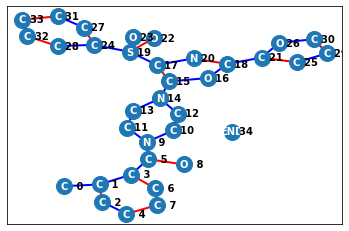

In [19]:
run(atom_y, bond_y)

In [7]:
atom_y.shape

torch.Size([24, 1, 4])

In [ ]:
model(g).shape

In [15]:
x = torch.Tensor([10, 3]).cuda()

In [18]:
y = torch.Tensor([5])
y = y.to(x)
y

tensor([5.], device='cuda:0')

In [8]:
bond_y.shape

torch.Size([24, 12, 1, 3])

In [ ]:
mask.shape

In [12]:
g

DGLGraph(num_nodes=3019, num_edges=9527,
         ndata_schemes={'feats': Scheme(shape=(56,), dtype=torch.float32)}
         edata_schemes={'feats': Scheme(shape=(11,), dtype=torch.float32)})

In [43]:
a = list(range(15))

In [44]:
a[:0:-1][:12]

[14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3]

In [37]:
a[::-1]

[1, 0]